<a href="https://colab.research.google.com/github/Trisha-K09/tamil-handwritten-recognition/blob/main/tamil_handwritten_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Step 2: Import necessary libraries
import os
import shutil
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.font_manager as fm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, GRU, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image



In [ ]:
# Step 3: Robust Tamil Font Setup
def setup_tamil_font():
    """Download and configure Tamil font for matplotlib rendering"""
    try:
        font_url = "https://github.com/google/fonts/raw/main/ofl/latha/Latha.ttf"  # Official Google Fonts mirror
        font_path = "/content/Latha.ttf"

        # Download font if not present
        if not os.path.exists(font_path):
            print("Downloading Latha Tamil font...")
            response = requests.get(font_url, timeout=10)
            response.raise_for_status()  # Check for download errors
            with open(font_path, "wb") as f:
                f.write(response.content)

        # Register font with matplotlib
        font_prop = fm.FontProperties(fname=font_path)
        fm.fontManager.addfont(font_path)
        plt.rcParams['font.family'] = 'Latha'
        print("✅ Tamil font configured successfully")
        return font_path

    except Exception as e:
        print(f"⚠️ Font setup warning: {str(e)}")
        print("Using default font - Tamil characters may not render properly")
        return None

# Usage (call this before any plotting)
font_path = setup_tamil_font()


⚠️ Font setup warning: name 'requests' is not defined
Using default font - Tamil characters may not render properly


In [ ]:
# Step 4: Define dataset paths
dataset_path = "/content/drive/My Drive/Tamil_dataset"
converted_dataset_path = "/content/drive/My Drive/Tamil_dataset_converted"
labeled_dataset_path = "/content/drive/My Drive/Tamil_dataset_labeled"
preprocessed_dataset_path = "/content/drive/My Drive/Tamil_dataset_preprocessed"

# Step 5: Tamil Uyir Ezhuthukkal and Ayyutha Ezhuthu mapped to phonetics and characters

tamil_to_phonetic = {
    # Vowels (1-13)
    "1": "a", "2": "aa", "3": "i", "4": "ii",
    "5": "u", "6": "uu", "7": "e", "8": "ee",
    "9": "ai", "10": "o", "11": "oo", "12": "au", "13": "ah",

    # Consonants + Pulli (14-31)
    "14": "k", "15": "ng", "16": "ch", "17": "nj",
    "18": "t", "19": "n", "20": "th", "21": "nd",
    "22": "p", "23": "m", "24": "y", "25": "r",
    "26": "l", "27": "v", "28": "zh", "29": "L",
    "30": "R", "31": "n",

    # Consonants + Inherent 'a' (32-49)
    "32": "ka", "33": "nga", "34": "cha", "35": "nja",
    "36": "ta", "37": "na", "38": "tha", "39": "nda",
    "40": "pa", "41": "ma", "42": "ya", "43": "ra",
    "44": "la", "45": "va", "46": "zha", "47": "La",
    "48": "Ra", "49": "na",

    # Uyirmei (50-67)
    "50": "ki", "51": "ngi", "52": "chi", "53": "nji",
    "54": "ti", "55": "ni", "56": "thi", "57": "ni",
    "58": "pi", "59": "mi", "60": "yi", "61": "ri",
    "62": "li", "63": "vi", "64": "zhi", "65": "Li",
    "66": "Ri", "67": "ni",


    # Uyirmei (69-86)
     "68": "kii", "69": "ngii", "70": "chii", "71": "njii",
     "72": "tii", "73": "nii", "74": "thii", "75": "nii",
     "76": "pii", "77": "mii", "78": "yii", "79": "rii",
     "80": "lii", "81": "vii", "82": "zhii", "83": "lii",
     "84": "rii", "85": "nii",

    # Uyirmei (86-103)
    "86": "ku", "87": "ngu", "88": "chu", "89": "nju",
    "90": "tu", "91": "nu", "92": "thu", "93": "ndu",
    "94": "pu", "95": "mu", "96": "yu", "97": "ru",
    "98": "lu", "99": "vu", "100": "zhu", "101": "Lu",
    "102": "Ru", "103": "nu",

    # Uyirmei (104-121)
    "104": "kuu", "105": "nguu", "106": "chuu", "107": "njuu",
    "108": "tuu", "109": "nuu", "110": "thuu", "111": "nduu",
    "112": "puu", "113": "muu", "114": "yuu", "115": "ruu",
    "116": "luu", "117": "vuu", "118": "zhuu", "119": "Luu",
    "120": "Ruu", "121": "nuu",

     "122": "aa_sign", "123": "e_sign", "124": "ee_sign", "125": "ai_sign"


}



tamil_unicode = {
    # Vowels (1-13)
     "1": "அ", "2": "ஆ", "3": "இ", "4": "ஈ",
     "5": "உ", "6": "ஊ", "7": "எ", "8": "ஏ",
     "9": "ஐ", "10": "ஒ", "11": "ஓ", "12": "ஔ", "13": "ஃ",

    # Consonants + Pulli (14-31)
    "14": "க்", "15": "ங்", "16": "ச்", "17": "ஞ்",
    "18": "ட்", "19": "ண்", "20": "த்", "21": "ந்",
    "22": "ப்", "23": "ம்", "24": "ய்", "25": "ர்",
    "26": "ல்", "27": "வ்", "28": "ழ்", "29": "ள்",
    "30": "ற்", "31": "ன்",

    # Consonants + Inherent 'a' (32-49)
    "32": "க", "33": "ங", "34": "ச", "35": "ஞ",
    "36": "ட", "37": "ண", "38": "த", "39": "ந",
    "40": "ப", "41": "ம", "42": "ய", "43": "ர",
    "44": "ல", "45": "வ", "46": "ழ", "47": "ள",
    "48": "ற", "49": "ன",

    # Uyirmei (50-67)
    "50": "கி", "51": "ஙி", "52": "சி", "53": "ஞி",
    "54": "டி", "55": "ணி", "56": "தி", "57": "நி",
    "58": "பி", "59": "மி", "60": "யி", "61": "ரி",
    "62": "லி", "63": "வி", "64": "ழி", "65": "ளி",
    "66": "றி", "67": "னி",

    # Uyirmei (69-86)
    "68": "கீ", "69": "ஙீ", "70": "சீ", "71": "ஞீ",
    "72": "டீ", "73": "ணீ", "74": "தீ", "75": "நீ",
    "76": "பீ", "77": "மீ", "78": "யீ", "79": "ரீ",
    "80": "லீ", "81": "வீ", "82": "ழீ", "83": "ளீ",
    "84": "றீ", "85": "னீ",

    #Uyirmei (86-103)
    "86": "கு","87":"ஙு","88":"சு","89": "ஞு",
    "90": "டு", "91": "ணு","92": "து", "93": "நு",
    "94": "பு","95": "மு","96": "யு","97": "ரு",
    "98": "லு","99": "வு", "100": "ழு","101": "ளு",
    "102": "று","103": "னு",


    #Uyirmei (104-121)
    "104": "கூ", "105": "ஙூ", "106": "சூ", "107": "ஞூ",
    "108": "டூ", "109": "ணூ", "110": "தூ", "111": "நூ",
    "112": "பூ", "113": "மூ", "114": "யூ", "115": "ரூ",
    "116": "லூ", "117": "வூ", "118": "ழூ", "119": "ளூ",
    "120": "றூ", "121": "னூ",

    #vowels
     "122": "ா", "123": "ெ", "124": "ே", "125": "ை"


}




In [ ]:
# Step 6: Convert BMP to PNG
if not os.path.exists(dataset_path):
    print(f"Dataset path not found: {dataset_path}. Please upload your dataset.")
else:
    os.makedirs(converted_dataset_path, exist_ok=True)
    folders = sorted(os.listdir(dataset_path))
    print("Folders in dataset:", folders)
    for folder in folders:
        folder_path = os.path.join(dataset_path, folder)
        converted_folder_path = os.path.join(converted_dataset_path, folder)
        os.makedirs(converted_folder_path, exist_ok=True)
        for img_file in os.listdir(folder_path):
            if img_file.lower().endswith('.bmp'):
                bmp_path = os.path.join(folder_path, img_file)
                png_file = img_file.replace('.bmp', '.png')
                png_path = os.path.join(converted_folder_path, png_file)
                try:
                    img = Image.open(bmp_path)
                    img.save(png_path, 'PNG')
                except Exception as e:
                    print(f"Error converting {bmp_path}: {e}")
            else:
                shutil.copy(os.path.join(folder_path, img_file), os.path.join(converted_folder_path, img_file))
    print("BMP to PNG conversion completed!")


Folders in dataset: ['1', '10', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']
BMP to PNG conversion completed!


In [ ]:
# Step 7: Verify and Label Dataset
if not os.path.exists(converted_dataset_path):
    print(f"Converted dataset path not found: {converted_dataset_path}.")
else:
    folders = sorted(os.listdir(converted_dataset_path))
    print("Folders in converted dataset:", folders)
    os.makedirs(labeled_dataset_path, exist_ok=True)
    for folder in folders:
        folder_path = os.path.join(converted_dataset_path, folder)
        new_folder_name = tamil_to_phonetic.get(folder, folder)
        new_folder_path = os.path.join(labeled_dataset_path, new_folder_name)
        os.makedirs(new_folder_path, exist_ok=True)
        for img_file in os.listdir(folder_path):
            old_img_path = os.path.join(folder_path, img_file)
            new_img_name = f"{new_folder_name}_{img_file}"
            new_img_path = os.path.join(new_folder_path, new_img_name)
            shutil.copy(old_img_path, new_img_path)
    print("Renaming and labeling completed!")


Folders in converted dataset: ['1', '10', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']
Renaming and labeling completed!


In [ ]:
# Step 8: Preprocess Images with Median Filtering
IMG_SIZE = (128, 128)  # Image size
os.makedirs(preprocessed_dataset_path, exist_ok=True)

def preprocess_image(image_path, target_size):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None
    # Apply median filtering to remove salt-and-pepper noise
    image = cv2.medianBlur(image, ksize=5)  # Kernel size 5x5 as per PDF
    image = cv2.resize(image, target_size)
    image = image / 255.0  # Normalize to [0, 1]
    return image

preprocessed_images = []
labels = []
for label in os.listdir(labeled_dataset_path):
    label_path = os.path.join(labeled_dataset_path, label)
    preprocessed_label_path = os.path.join(preprocessed_dataset_path, label)
    os.makedirs(preprocessed_label_path, exist_ok=True)
    for img_file in os.listdir(label_path):
        img_path = os.path.join(label_path, img_file)
        preprocessed_img = preprocess_image(img_path, IMG_SIZE)
        if preprocessed_img is not None:
            preprocessed_images.append(preprocessed_img)
            labels.append(label)
            preprocessed_img_path = os.path.join(preprocessed_label_path, img_file)
            cv2.imwrite(preprocessed_img_path, preprocessed_img * 255)
preprocessed_images = np.array(preprocessed_images)
labels = np.array(labels)

# Check class distribution
unique_labels, counts = np.unique(labels, return_counts=True)
print("Class distribution:")
for label, count in zip(unique_labels, counts):
    print(f"{label}: {count} samples")

np.save(os.path.join(preprocessed_dataset_path, "preprocessed_images.npy"), preprocessed_images)
np.save(os.path.join(preprocessed_dataset_path, "labels.npy"), labels)
print("Data preprocessing completed!")
print(f"Preprocessed images shape: {preprocessed_images.shape}")
print(f"Labels shape: {labels.shape}")


Class distribution:
L: 80 samples
La: 82 samples
Li: 81 samples
Lu: 81 samples
Luu: 80 samples
R: 81 samples
Ra: 80 samples
Ri: 84 samples
Ru: 81 samples
Ruu: 81 samples
a: 10 samples
aa: 12 samples
aa_sign: 81 samples
ah: 80 samples
ai: 80 samples
ai_sign: 81 samples
au: 80 samples
ch: 80 samples
cha: 80 samples
chi: 80 samples
chii: 80 samples
chu: 80 samples
chuu: 80 samples
e: 80 samples
e_sign: 81 samples
ee: 80 samples
ee_sign: 81 samples
i: 80 samples
ii: 80 samples
k: 80 samples
ka: 80 samples
ki: 80 samples
kii: 80 samples
ku: 80 samples
kuu: 80 samples
l: 81 samples
la: 81 samples
li: 81 samples
lii: 177 samples
lu: 81 samples
luu: 81 samples
m: 80 samples
ma: 80 samples
mi: 80 samples
mii: 80 samples
mu: 80 samples
muu: 80 samples
n: 161 samples
na: 160 samples
nd: 80 samples
nda: 80 samples
ndu: 80 samples
nduu: 80 samples
ng: 80 samples
nga: 80 samples
ngi: 80 samples
ngii: 80 samples
ngu: 80 samples
nguu: 80 samples
ni: 241 samples
nii: 241 samples
nj: 80 samples
nja: 80 

In [ ]:
# Step 9: Encode Labels and Split Data
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)
X_train, X_temp, y_train, y_temp = train_test_split(preprocessed_images, y_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
X_train = X_train.reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 1)
X_val = X_val.reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 1)
X_test = X_test.reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 1)


In [ ]:
# Step 10: Define Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    fill_mode='nearest'
)
datagen.fit(X_train)


In [ ]:
# Step 11: Define CNN-GRU Model
from tensorflow.keras.layers import Reshape
model_cnn_gru = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    # Reshape the output of Flatten to be 3D for GRU
    Reshape((1, -1)),  # Reshape to (batch_size, 1, features) - consider adjusting '1' to match desired timesteps
    GRU(256, return_sequences=False),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])
model_cnn_gru.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_cnn_gru.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 25088)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 256)            │    19,465,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 115)            │        14,835 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,606,131 (74.79 MB)

 Trainable params: 19,606,131 (74.79 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Step 12: Define CNN-LSTM Model
model_cnn_lstm = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    # Reshape the output before the LSTM layer
    # to have the shape (samples, timesteps, features)
    Reshape((-1, 128)),  # Assuming 128 features after the convolutional layers, adjust if needed
    LSTM(256, return_sequences=False),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])
model_cnn_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_cnn_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 196, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 115)            │        14,835 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 534,643 (2.04 MB)

 Trainable params: 534,643 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# Step 13: Define Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)


NameError: name 'EarlyStopping' is not defined

In [ ]:
# Step 14: Train Models
history_cnn_gru = model_cnn_gru.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=70,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

history_cnn_lstm = model_cnn_lstm.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/70


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


219/219 ━━━━━━━━━━━━━━━━━━━━ 19s 65ms/step - accuracy: 0.0197 - loss: 4.7221 - val_accuracy: 0.1681 - val_loss: 3.6453 - learning_rate: 0.0010
Epoch 2/70
219/219 ━━━━━━━━━━━━━━━━━━━━ 13s 61ms/step - accuracy: 0.1168 - loss: 3.8690 - val_accuracy: 0.5404 - val_loss: 2.0748 - learning_rate: 0.0010
Epoch 3/70
219/219 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.2300 - loss: 3.0476 - val_accuracy: 0.6391 - val_loss: 1.5240 - learning_rate: 0.0010
Epoch 4/70
219/219 ━━━━━━━━━━━━━━━━━━━━ 13s 61ms/step - accuracy: 0.3471 - loss: 2.5181 - val_accuracy: 0.7091 - val_loss: 1.1971 - learning_rate: 0.0010
Epoch 5/70
219/219 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - accuracy: 0.4009 - loss: 2.2477 - val_accuracy: 0.7572 - val_loss: 0.9894 - learning_rate: 0.0010
Epoch 6/70
219/219 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - accuracy: 0.4603 - loss: 2.0102 - val_accuracy: 0.7532 - val_loss: 0.9305 - learning_rate: 0.0010
Epoch 7/70
219/219 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.4937 - loss: 1.8195

In [ ]:

# Step 15: Evaluate Models
test_loss_cnn_gru, test_acc_cnn_gru = model_cnn_gru.evaluate(X_test, y_test, verbose=0)
print("CNN-GRU Test Accuracy:", test_acc_cnn_gru)
test_loss_cnn_lstm, test_acc_cnn_lstm = model_cnn_lstm.evaluate(X_test, y_test, verbose=0)
print("CNN-LSTM Test Accuracy:", test_acc_cnn_lstm)


CNN-GRU Test Accuracy: 0.9299424290657043
CNN-LSTM Test Accuracy: 0.8857965469360352


CNN-GRU Prediction: na ண (Confidence: 98.42%)


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2979 (\N{TAMIL LETTER NNA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Tamil natively.
  fig.canvas.print_figure(bytes_io, **kw)


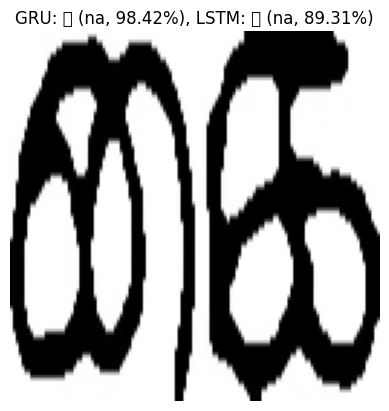

In [ ]:
# Step 17: Predict on a Single Image with Confidence Scores
def preprocess_input_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Error: Could not load image at {image_path}")
        return None
    image = cv2.medianBlur(image, ksize=5)  # Apply median filtering
    image = cv2.resize(image, IMG_SIZE)
    image = image / 255.0
    image = image.reshape(1, IMG_SIZE[0], IMG_SIZE[1], 1)
    return image
input_image_path = "/content/drive/My Drive/tamil_kai.png"

input_image = preprocess_input_image(input_image_path)
if input_image is not None:
    pred_gru = model_cnn_gru.predict(input_image, verbose=0)
    pred_lstm = model_cnn_lstm.predict(input_image, verbose=0)
    pred_label_gru = np.argmax(pred_gru, axis=1)[0]
    pred_label_lstm = np.argmax(pred_lstm, axis=1)[0]
    confidence_gru = np.max(pred_gru) * 100
    confidence_lstm = np.max(pred_lstm) * 100
    phonetic_gru = label_encoder.inverse_transform([pred_label_gru])[0]
    phonetic_lstm = label_encoder.inverse_transform([pred_label_lstm])[0]
    # Instead of directly accessing the list, use the key to get the value.
    tamil_char_gru = tamil_unicode.get(str([k for k, v in tamil_to_phonetic.items() if v == phonetic_gru][0]), "Unknown")
    tamil_char_lstm = tamil_unicode.get(str([k for k, v in tamil_to_phonetic.items() if v == phonetic_lstm][0]), "Unknown")
    print(f"CNN-GRU Prediction: {phonetic_gru} {tamil_char_gru} (Confidence: {confidence_gru:.2f}%)")
  #  print(f"CNN-LSTM Prediction: {phonetic_lstm} {tamil_char_lstm} (Confidence: {confidence_lstm:.2f}%)")
    plt.imshow(input_image.reshape(IMG_SIZE[0], IMG_SIZE[1]), cmap='gray')
    # Explicitly setting the font family for the title
    # Ensure the font is loaded using fm.FontProperties with both family and fname
#    font = fm.FontProperties(family='Latha', fname=font_path)
    # Check if the font is loaded successfully


    plt.title(f"GRU: {tamil_char_gru} ({phonetic_gru}, {confidence_gru:.2f}%), LSTM: {tamil_char_lstm} ({phonetic_lstm}, {confidence_lstm:.2f}%)"
            )
    plt.axis('off')
plt.show()